# Automated rule-based Bayesian classification analysis for the power plant data

Load the packages

In [1]:
from numpy.core.numeric import NaN
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from scipy.stats import logistic
from sklearn import metrics

np.random.seed(123)

Load the data

In [2]:
df = pd.read_excel("Folds5x2_pp.xlsx")

PE_cuttof = 465
AT_cuttof = 20

df_train_inter = df.head(1000)
df_train = df_train_inter[df_train_inter["AT"] <= AT_cuttof]

Plot the data

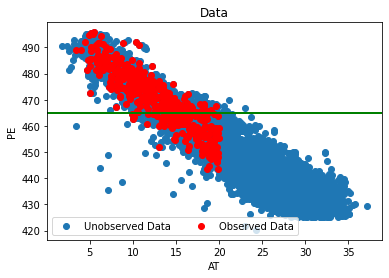

In [3]:
fig, ax = plt.subplots()
ax.scatter(df["AT"], df["PE"], label="Unobserved Data")
ax.scatter(df_train["AT"], df_train["PE"], c="red", label="Observed Data")
ax.set_xlabel("AT")
ax.set_ylabel("PE")
ax.set_title("Data")
plt.axhline(PE_cuttof, c="g", linewidth=2)
ax.legend(ncol=2, fontsize=10)
# fig.savefig("pp_data.png", dpi=300, bbox_inches="tight", facecolor="w")

Create class variable and scale the data

In [5]:
df_train = df_train.assign(
    PE_class=lambda dataframe: dataframe["PE"].map(
        lambda PE: 1 if PE >= PE_cuttof else 0
    )
)

X_train = df_train.drop(columns=["PE", "PE_class"]).to_numpy()
scaler = StandardScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)

df_test = df
df_test = df_test.assign(
    PE_class=lambda dataframe: dataframe["PE"].map(
        lambda PE: 1 if PE >= PE_cuttof else 0
    )
)
df_testsc = scaler.transform(df_test.drop(columns=["PE", "PE_class"]))

df_test.PE_class.value_counts()

0    6609
1    2959
Name: PE_class, dtype: int64

## Bayesian multivariate logistic regression

Define the features and label

In [6]:
AT_val = X_train_sc[:, 0]
V_val = X_train_sc[:, 1]
AP_val = X_train_sc[:, 2]
RH_val = X_train_sc[:, 3]

PEclass_val = df_train.PE_class.to_numpy()

Run the model

In [7]:
with pm.Model() as model_norules:
    # define priors
    AT_co = pm.Normal("AT_co", 0.0, 10.0)
    V_co = pm.Normal("V_co", 0.0, 10.0)
    AP_co = pm.Normal("AP_co", 0.0, 10.0)
    RH_co = pm.Normal("RH_co", 0.0, 10.0)
    b = pm.Normal("intercept", 0, 20.0)
    s = pm.Exponential("error", 1)

    res = pm.math.sigmoid(
        AT_co * AT_val + V_co * V_val + AP_co * AP_val + RH_co * RH_val + b
    )

    # predictions
    obs = pm.Bernoulli("observation", res, observed=PEclass_val)

# Run the MCMC
with model_norules:
    step = pm.Metropolis(scaling=0.01)
    trace_norules = pm.sample(draws=100000, step=step, tune=20000, cores=1, chains=1)

<ipython-input-7-e52aa0446030>:20: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_norules = pm.sample(draws=100000, step=step, tune=20000, cores=1, chains=1)
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [error]
>Metropolis: [intercept]
>Metropolis: [RH_co]
>Metropolis: [AP_co]
>Metropolis: [V_co]
>Metropolis: [AT_co]


Sampling 1 chain for 20_000 tune and 100_000 draw iterations (20_000 + 100_000 draws total) took 117 seconds.
/usr/local/anaconda3/envs/daskk/lib/python3.8/site-packages/arviz/data/base.py:216: UserWarning: More chains (100000) than draws (6). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only one chain was sampled, this makes it impossible to run some convergence checks


Evaluate metrics

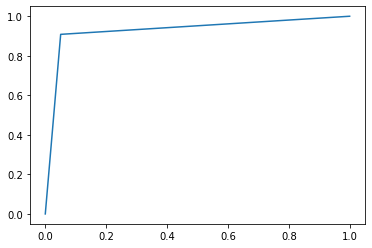

accuracy: 0.9367683946488294
AUC: 0.928938929376825
sensitivity: 0.9084150050692802


In [9]:
pred = (
    trace_norules["AT_co"].mean() * df_testsc[:, 0]
    + trace_norules["V_co"].mean() * df_testsc[:, 1]
    + trace_norules["AP_co"].mean() * df_testsc[:, 2]
    + trace_norules["RH_co"].mean() * df_testsc[:, 3]
    + trace_norules["intercept"].mean()
)

pred_log = logistic.cdf(pred)
final_pred = [1 if pred_log[j] >= 0.5 else 0 for j in range(pred_log.shape[0])]
final_pred = np.array(final_pred)

fpr, tpr, _ = metrics.roc_curve(df_test.PE_class, final_pred)
auc = metrics.roc_auc_score(df_test.PE_class, final_pred)

tn, fp, fn, tp = confusion_matrix(df_test.PE_class, final_pred).ravel()
sensitivity = tp / (tp + fn)

plt.plot(fpr, tpr)
plt.show()

print("accuracy:",str(accuracy_score(df_test.PE_class, final_pred)))
print("AUC:",str(auc))
print("sensitivity:",str(sensitivity))

## Rule-based Bayesian multivariate logistic regression (AT rules)


Define the rule

In [10]:
np.random.seed(456)

no_points = 25
xlow = min(AT_val)
xmid = 0.45
xhi = max(AT_val)

rule_first = np.linspace(xlow, xmid, no_points)
rule_second = np.linspace(xmid, xhi, no_points)

ymid = 0.5


def logp_rule_nopm(
    AT_co, b_lat,
):

    points_r1 = pm.math.sigmoid(rule_first * AT_co + b_lat)
    points_r2 = pm.math.sigmoid(rule_second * AT_co + b_lat)

    rule_log_lik = 0
    for i in range(no_points):
        rule_log_lik = rule_log_lik + pm.math.switch(
            pm.math.lt(points_r1[i], ymid), 1, 0
        )
        rule_log_lik = rule_log_lik + pm.math.switch(
            pm.math.gt(points_r2[i], ymid), 1, 0
        )

    rule_ratio = rule_log_lik / (2 * no_points)

    return pm.Beta.dist(alpha=1.0, beta=10000.0).logp(rule_ratio)

Run the model

In [11]:
with pm.Model() as model_ATrules:
    # define priors
    AT_co = pm.Normal("AT_co", 0.0, 10.0)
    V_co = pm.Normal("V_co", 0.0, 10.0)
    AP_co = pm.Normal("AP_co", 0.0, 10.0)
    RH_co = pm.Normal("RH_co", 0.0, 10.0)
    b = pm.Normal("intercept", 0, 20.0)
    s = pm.Exponential("error", 1)

    b_lat = pm.Normal("intercept_lat", 0, 10.0)

    res = pm.math.sigmoid(
        AT_co * AT_val + V_co * V_val + AP_co * AP_val + RH_co * RH_val + b
    )

    # predictions
    obs = pm.Bernoulli("observation", res, observed=PEclass_val)
    L_rule = pm.Potential("LL_rule", logp_rule_nopm(AT_co, b_lat))

# Run the MCMC
with model_ATrules:
    step = pm.Metropolis(scaling=0.01)
    trace_ATrules = pm.sample(draws=100000, step=step, tune=20000, cores=1, chains=1)

<ipython-input-11-a7e355831812>:23: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_ATrules = pm.sample(draws=100000, step=step, tune=20000, cores=1, chains=1)
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [intercept_lat]
>Metropolis: [error]
>Metropolis: [intercept]
>Metropolis: [RH_co]
>Metropolis: [AP_co]
>Metropolis: [V_co]
>Metropolis: [AT_co]


Sampling 1 chain for 20_000 tune and 100_000 draw iterations (20_000 + 100_000 draws total) took 158 seconds.
/usr/local/anaconda3/envs/daskk/lib/python3.8/site-packages/arviz/data/base.py:216: UserWarning: More chains (100000) than draws (7). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only one chain was sampled, this makes it impossible to run some convergence checks


Evaluate metrics

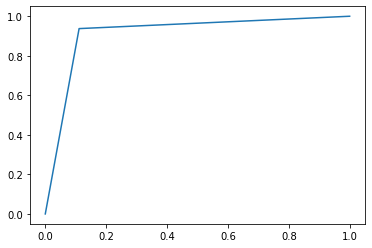

accuracy: 0.903950668896321
AUC: 0.9132091015809904
sensitivity: 0.9374788779993241


In [12]:
pred = (
    trace_ATrules["AT_co"].mean() * df_testsc[:, 0]
    + trace_ATrules["V_co"].mean() * df_testsc[:, 1]
    + trace_ATrules["AP_co"].mean() * df_testsc[:, 2]
    + trace_ATrules["RH_co"].mean() * df_testsc[:, 3]
    + trace_ATrules["intercept"].mean()
)

pred_log = logistic.cdf(pred)
final_pred_AT = [1 if pred_log[j] >= 0.5 else 0 for j in range(pred_log.shape[0])]
final_pred_AT = np.array(final_pred_AT)

fpr, tpr, _ = metrics.roc_curve(df_test.PE_class, final_pred_AT)
auc_AT = metrics.roc_auc_score(df_test.PE_class, final_pred_AT)

plt.plot(fpr, tpr)
plt.show()

tn, fp, fn, tp = confusion_matrix(df_test.PE_class, final_pred_AT).ravel()
sensitivity_AT = tp / (tp + fn)

print("accuracy:",str(accuracy_score(df_test.PE_class, final_pred_AT)))
print("AUC:",str(auc_AT))
print("sensitivity:",str(sensitivity_AT))

Compare ROC curves

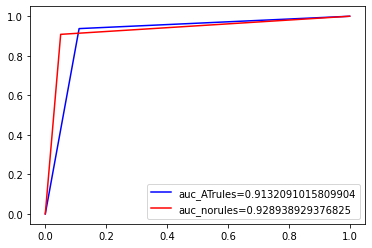

In [15]:
fpr, tpr, _ = metrics.roc_curve(df_test.PE_class, final_pred_AT)
fpr2, tpr2, _ = metrics.roc_curve(df_test.PE_class, final_pred)
auc = metrics.roc_auc_score(df_test.PE_class, final_pred_AT)
auc2 = metrics.roc_auc_score(df_test.PE_class, final_pred)
plt.plot(fpr, tpr, c="b", label="auc_ATrules=" + str(auc))
plt.plot(fpr2, tpr2, c="r", label="auc_norules=" + str(auc2))
plt.legend(loc=4)
plt.show()